## Contents
* Reading Data
* Visualization
* Preprocessing
* Training The Model
* Visualizing The Model
* Predictions

In [1]:
import os
import pydotplus
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image
%matplotlib inline

In [2]:
data_root = 'data'
train_file = os.path.join(data_root,'train.csv')
test_file = os.path.join(data_root,'test.csv')
test_label_file = os.path.join(data_root,'gender_submission.csv')

## Reading Data

In [3]:
training_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
test_label = pd.read_csv(test_label_file)

In [8]:
td_not_survived=training_data.loc[(training_data['Survived']==0)]
td_survived=training_data.loc[(training_data['Survived']==1)]

## Visualization

In [4]:
training_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
print('Null Number In Diffrent Columns : ')
test_data.isnull().sum()

Null Number In Diffrent Columns : 


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
print('Null Number In Diffrent Columns : ')
training_data.isnull().sum()

Null Number In Diffrent Columns : 


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Text(0.5,1,'Survival Rate by Embarked')

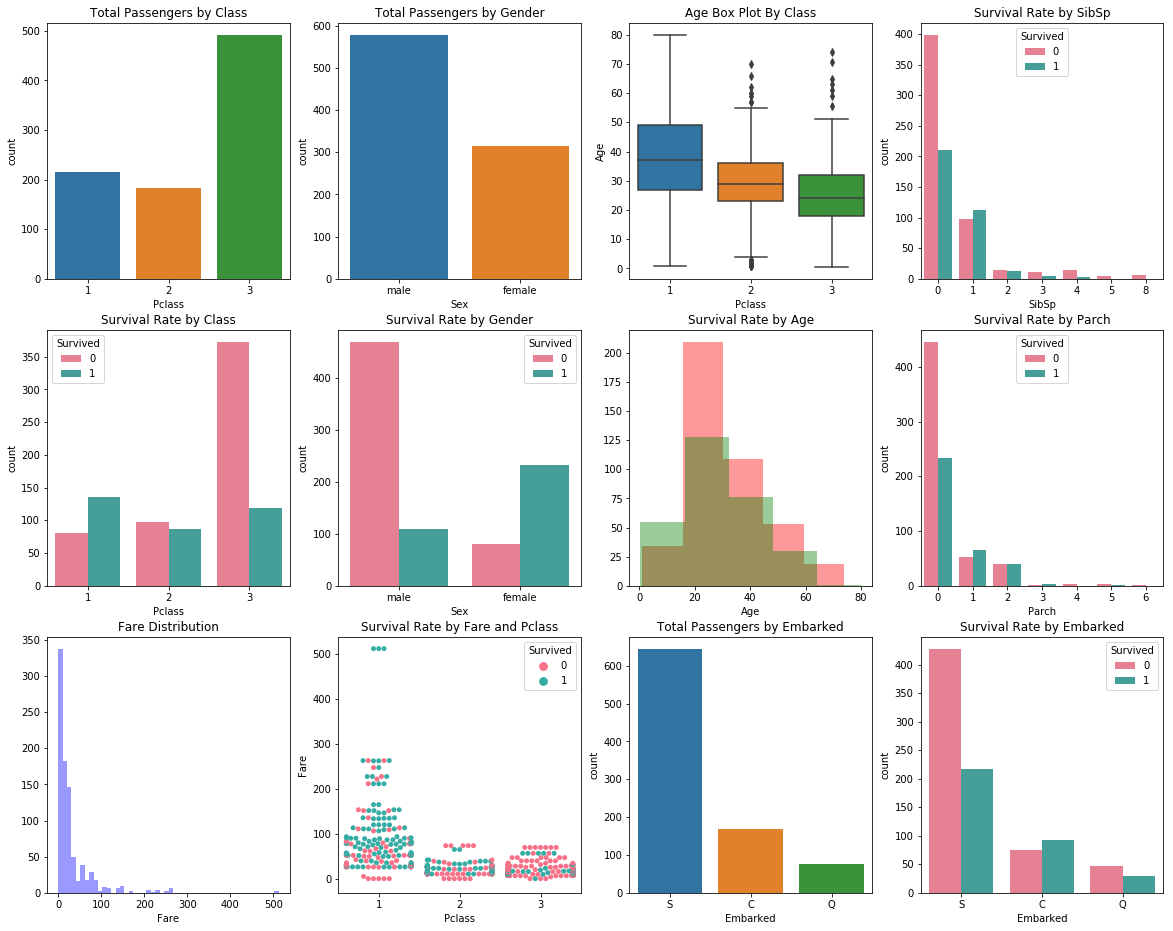

In [9]:
f,ax = plt.subplots(3,4,figsize=(20,16))
sns.countplot('Pclass',data=training_data,ax=ax[0,0])
sns.countplot('Sex',data=training_data,ax=ax[0,1])
sns.boxplot(x='Pclass',y='Age',data=training_data,ax=ax[0,2])
sns.countplot('SibSp',hue='Survived',data=training_data,ax=ax[0,3],palette='husl')
sns.distplot(training_data['Fare'].dropna(),ax=ax[2,0],kde=False,color='b')
sns.countplot('Embarked',data=training_data,ax=ax[2,2])

sns.countplot('Pclass',hue='Survived',data=training_data,ax=ax[1,0],palette='husl')
sns.countplot('Sex',hue='Survived',data=training_data,ax=ax[1,1],palette='husl')
sns.distplot(training_data[training_data['Survived']==0]['Age'].dropna(),ax=ax[1,2],kde=False,color='r',bins=5)
sns.distplot(training_data[training_data['Survived']==1]['Age'].dropna(),ax=ax[1,2],kde=False,color='g',bins=5)
sns.countplot('Parch',hue='Survived',data=training_data,ax=ax[1,3],palette='husl')
sns.swarmplot(x='Pclass',y='Fare',hue='Survived',data=training_data,palette='husl',ax=ax[2,1])
sns.countplot('Embarked',hue='Survived',data=training_data,ax=ax[2,3],palette='husl')

ax[0,0].set_title('Total Passengers by Class')
ax[0,1].set_title('Total Passengers by Gender')
ax[0,2].set_title('Age Box Plot By Class')
ax[0,3].set_title('Survival Rate by SibSp')
ax[1,0].set_title('Survival Rate by Class')
ax[1,1].set_title('Survival Rate by Gender')
ax[1,2].set_title('Survival Rate by Age')
ax[1,3].set_title('Survival Rate by Parch')
ax[2,0].set_title('Fare Distribution')
ax[2,1].set_title('Survival Rate by Fare and Pclass')
ax[2,2].set_title('Total Passengers by Embarked')
ax[2,3].set_title('Survival Rate by Embarked')

## Preprosessing

In [10]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 
                    'Countess', 'Don', 'Jonkheer']
def substring_extractor(string,substrings) :
    for substring in substrings:
        
        if string.find(substring) != -1 :
            return substring
    return np.nan

def replace_titles(row):
    title = row['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if row['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

### Train Data

In [11]:
p_data = training_data.loc[:]
p_data['Title'] = p_data['Name'].apply(lambda row:substring_extractor(row,title_list))
p_data['Title'] = p_data.apply(replace_titles,axis=1) # Reducing Titles
p_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### Test Data

In [12]:
p_test_data = test_data.loc[:]
p_test_data['Title'] = p_test_data['Name'].apply(lambda row:substring_extractor(row,title_list))
p_test_data['Title'] = p_test_data.apply(replace_titles,axis=1) # Reducing Titles
p_test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [13]:
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
p_data['Deck']= p_data['Cabin'].fillna('Unknown').apply(lambda row: substring_extractor(row, cabin_list))

In [14]:
p_test_data['Deck']= p_test_data['Cabin'].fillna('Unknown').apply(lambda row: substring_extractor(row, cabin_list))

In [15]:
p_test_data.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
382,1274,3,"Risien, Mrs. Samuel (Emma)",female,NaN,0,0,364498,14.50,NaN,S,Mrs,Unknown
147,1039,3,"Davies, Mr. Evan",male,22.0,0,0,SC/A4 23568,8.05,NaN,S,Mr,Unknown
352,1244,2,"Dibden, Mr. William",male,18.0,0,0,S.O.C. 14879,73.50,NaN,S,Mr,Unknown
231,1123,1,"Willard, Miss. Constance",female,21.0,0,0,113795,26.55,NaN,S,Miss,Unknown
278,1170,2,"Ware, Mr. John James",male,30.0,1,0,CA 31352,21.00,NaN,S,Mr,Unknown


In [16]:
p_data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
391,392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,NaN,S,Mr,Unknown
781,782,1,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.0000,B20,S,Mrs,B
254,255,0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.0,0,2,370129,20.2125,NaN,S,Mrs,Unknown
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,Mr,Unknown
354,355,0,3,"Yousif, Mr. Wazli",male,NaN,0,0,2647,7.2250,NaN,C,Mr,Unknown


In [17]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
p_data['Age'] = imp.fit_transform(p_data['Age'].values.reshape(-1,1)).reshape(-1)
p_data = p_data.dropna()
target = p_data['Survived']
pp_data = p_data.drop(['Name','Ticket','Cabin','PassengerId','Survived'],axis=1)
print('Null Number In Diffrent Columns : ')
pp_data.isnull().sum()

Null Number In Diffrent Columns : 


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
Deck        0
dtype: int64

In [18]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
p_test_data['Age'] = imp.fit_transform(p_test_data['Age'].values.reshape(-1,1)).reshape(-1)
p_test_data['Fare'] = imp.fit_transform(p_test_data['Fare'].values.reshape(-1,1)).reshape(-1)
pp_test_data = p_test_data.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
print('Null Number In Diffrent Columns : ')
pp_test_data.isnull().sum()

Null Number In Diffrent Columns : 


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
Deck        0
dtype: int64

In [19]:
pp_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
1,1,female,38.0,1,0,71.2833,C,Mrs,C
3,1,female,35.0,1,0,53.1000,S,Mrs,C
6,1,male,54.0,0,0,51.8625,S,Mr,E
10,3,female,4.0,1,1,16.7000,S,Miss,G
11,1,female,58.0,0,0,26.5500,S,Miss,C


In [20]:
pp_test_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
0,3,male,34.5,0,0,7.8292,Q,Mr,Unknown
1,3,female,47.0,1,0,7.0000,S,Mrs,Unknown
2,2,male,62.0,0,0,9.6875,Q,Mr,Unknown
3,3,male,27.0,0,0,8.6625,S,Mr,Unknown
4,3,female,22.0,1,1,12.2875,S,Mrs,Unknown


In [21]:
le = LabelEncoder()

pp_data['Sex'] = le.fit_transform(pp_data['Sex'])
pp_data['Embarked'] = le.fit_transform(pp_data['Embarked'])
pp_data['Title'] = le.fit_transform(pp_data['Title'])
pp_data['Deck'] = le.fit_transform(pp_data['Deck'])

In [22]:
pp_test_data['Sex'] = le.fit_transform(pp_test_data['Sex'])
pp_test_data['Embarked'] = le.fit_transform(pp_test_data['Embarked'])
pp_test_data['Title'] = le.fit_transform(pp_test_data['Title'])
pp_test_data['Deck'] = le.fit_transform(pp_test_data['Deck'])

In [23]:
pp_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
1,1,0,38.0,1,0,71.2833,0,3,2
3,1,0,35.0,1,0,53.1000,2,3,2
6,1,1,54.0,0,0,51.8625,2,2,4
10,3,0,4.0,1,1,16.7000,2,1,6
11,1,0,58.0,0,0,26.5500,2,1,2


In [24]:
pp_test_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
0,3,1,34.5,0,0,7.8292,1,2,7
1,3,0,47.0,1,0,7.0000,2,3,7
2,2,1,62.0,0,0,9.6875,1,2,7
3,3,1,27.0,0,0,8.6625,2,2,7
4,3,0,22.0,1,1,12.2875,2,3,7


## Training The Model

In [25]:
dtree = DecisionTreeClassifier()
model = dtree.fit(pp_data,target)

## Visualizing The Model

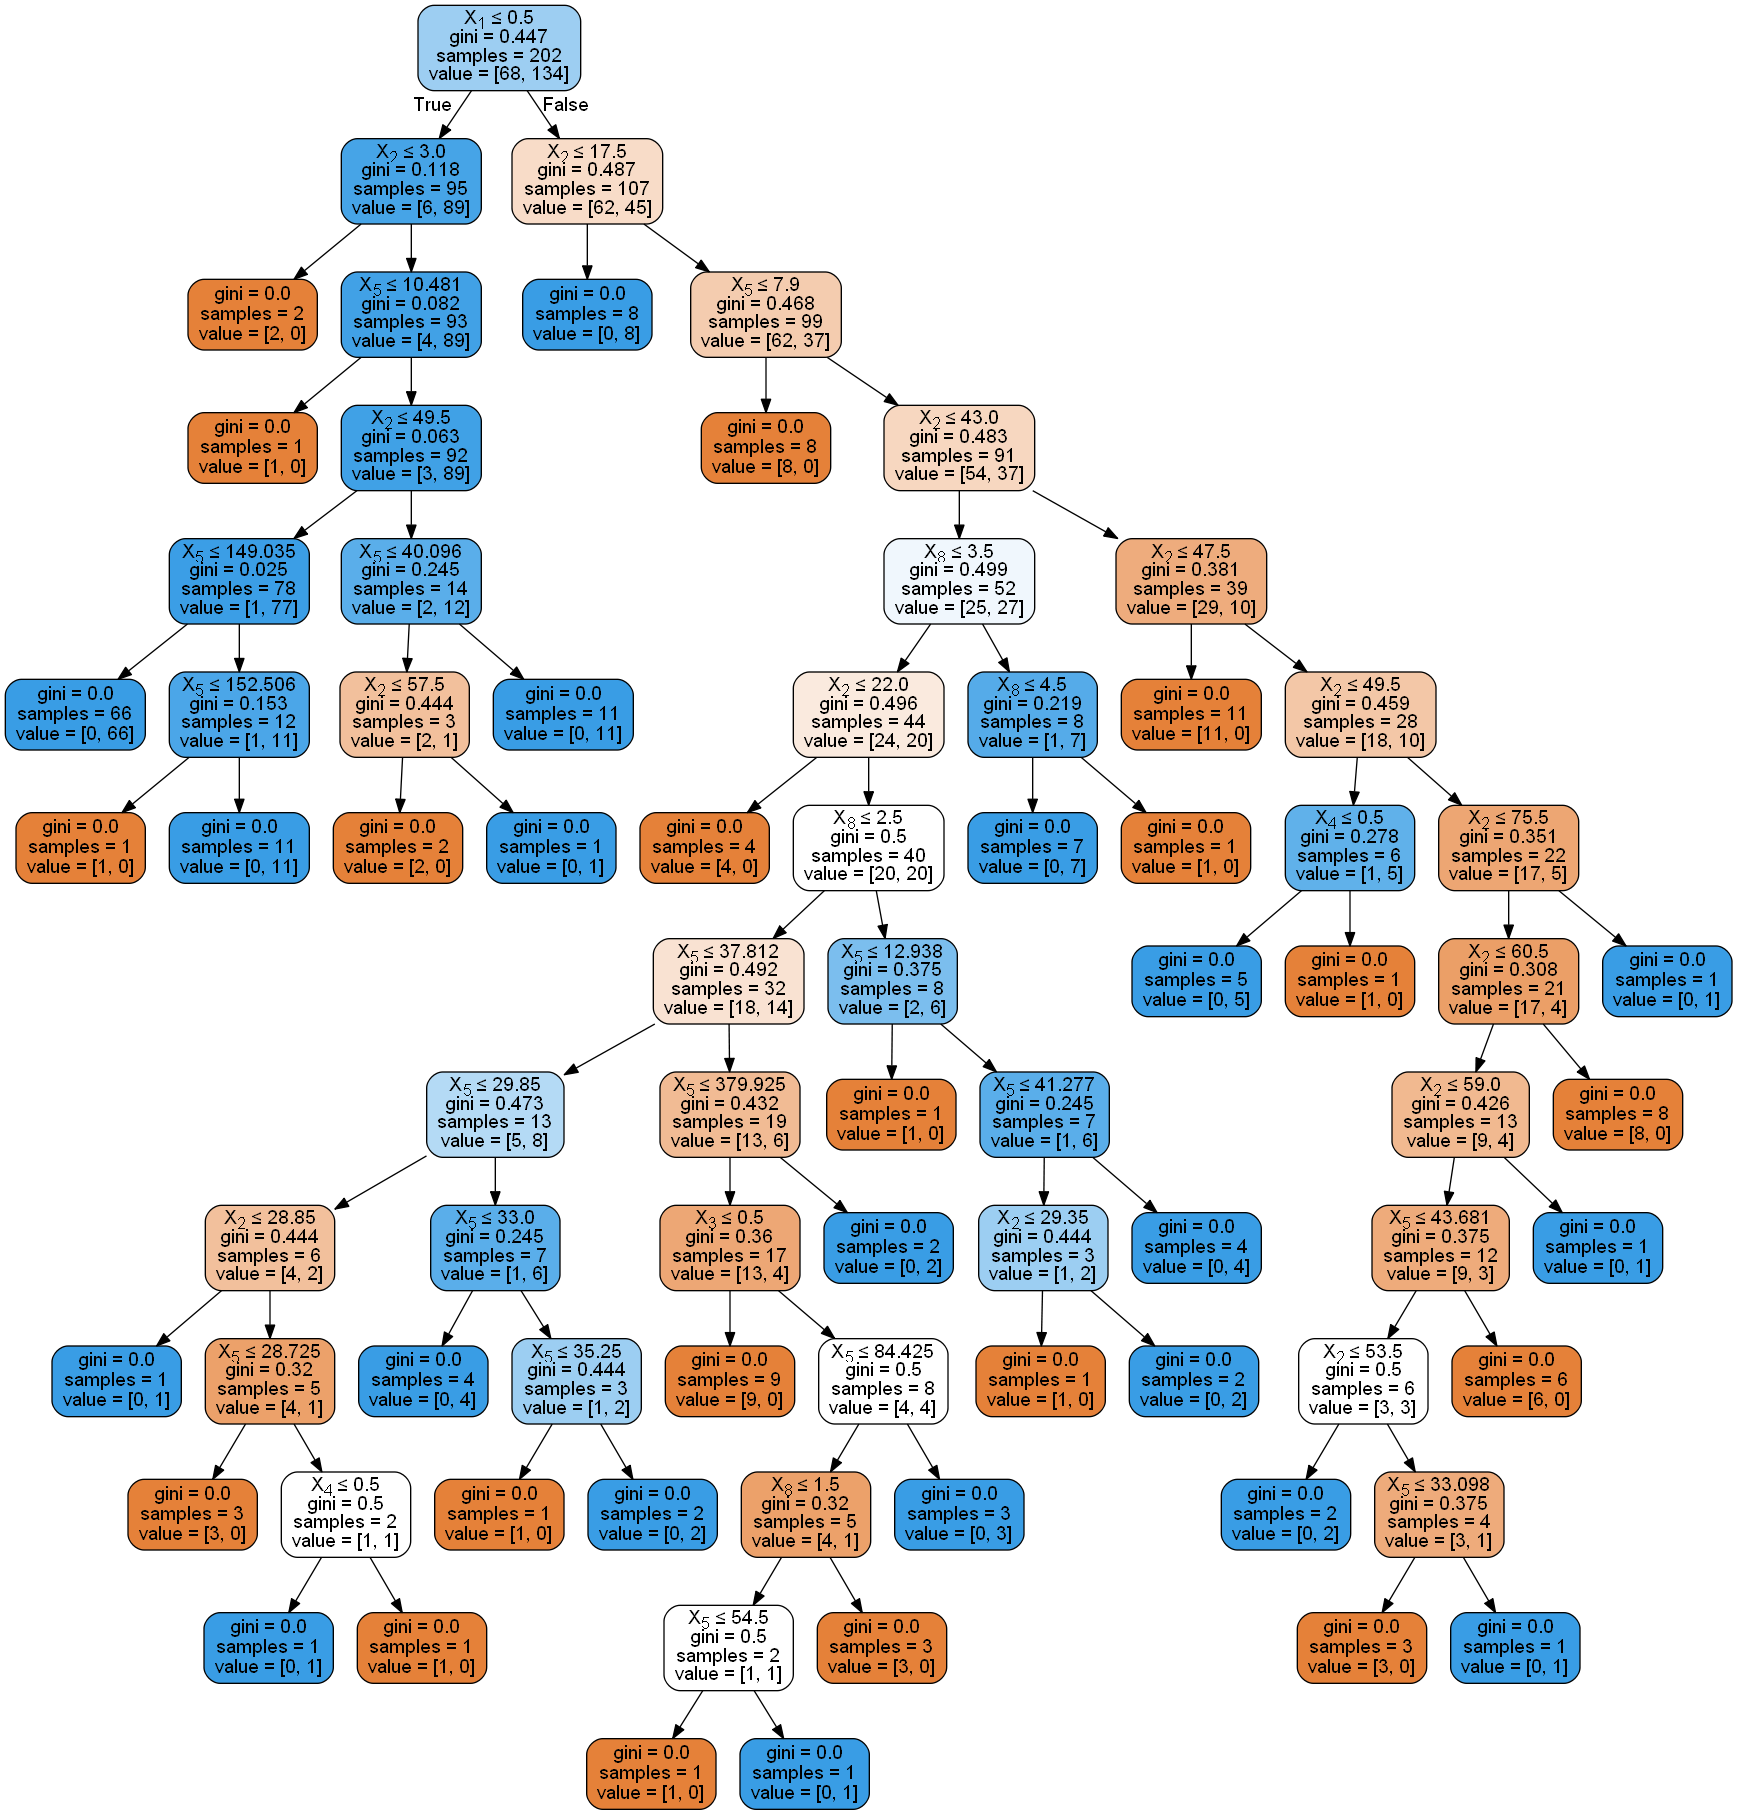

In [26]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Prediction

In [27]:
print('Accuracy On Train Set : %{}'.format(sum(model.predict(pp_data) == target)*100/len(target)))

Accuracy On Train Set : %100.0


In [28]:
print('Accuracy On Test Set : %{}'.format(sum(model.predict(pp_test_data) == test_label['Survived'])*100/len(test_label)))

Accuracy On Test Set : %76.79425837320574
